In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("cropdata_updated.csv")

In [3]:
df.head()

,crop ID,soil_type,Seedling Stage,MOI,temp,humidity,result
0,Wheat,Black Soil,Germination,1,25,80.0,1
1,Wheat,Black Soil,Germination,2,26,77.0,1
2,Wheat,Black Soil,Germination,3,27,74.0,1
3,Wheat,Black Soil,Germination,4,28,71.0,1
4,Wheat,Black Soil,Germination,5,29,68.0,1


In [4]:
# drop these where result value is 2
before = len(df)
df = df[df['result'] != 2]
after = len(df)

print(f"Removed {before - after} rows")

Removed 1122 rows


In [5]:
df.shape

(15289, 7)

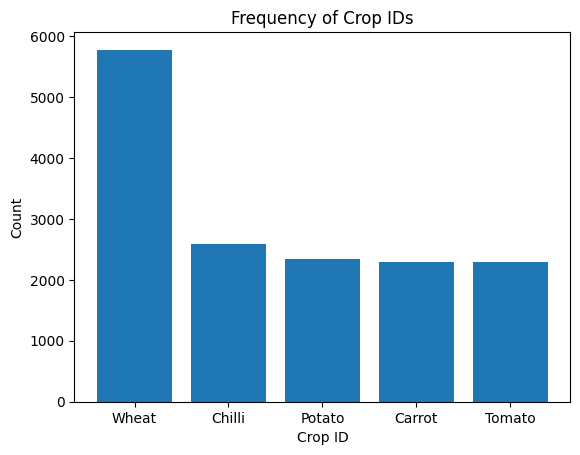

In [6]:
counts = df['crop ID'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('Crop ID')
plt.ylabel('Count')
plt.title('Frequency of Crop IDs')
plt.show()

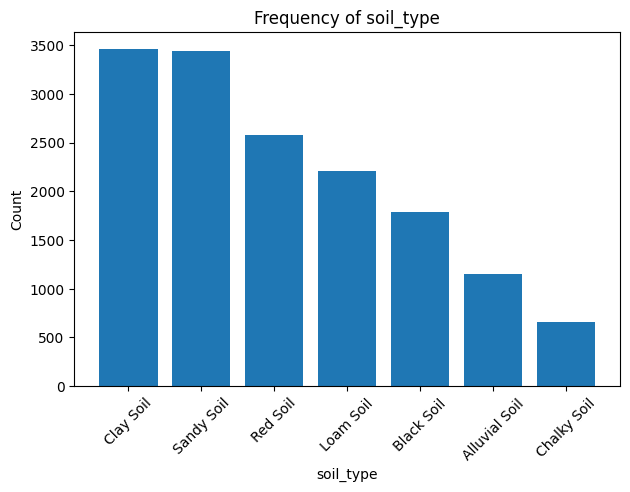

In [7]:
counts = df['soil_type'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('soil_type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Frequency of soil_type')
plt.show()

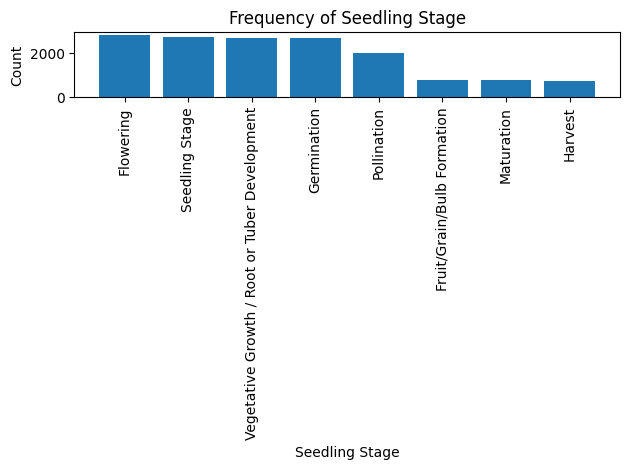

In [8]:
counts = df['Seedling Stage'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('Seedling Stage')
plt.ylabel('Count')
plt.title('Frequency of Seedling Stage')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

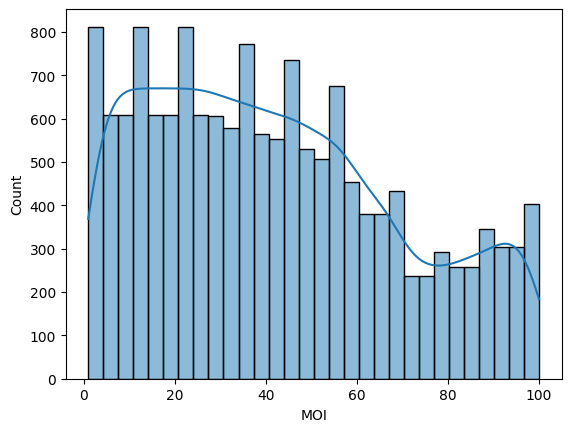

In [9]:
sns.histplot(data = df , x = 'MOI' , kde = True)
plt.show()

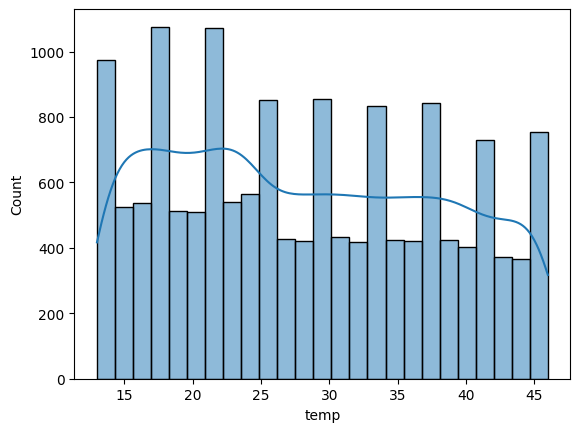

In [10]:
sns.histplot(data = df , x = 'temp' , kde = True)
plt.show()

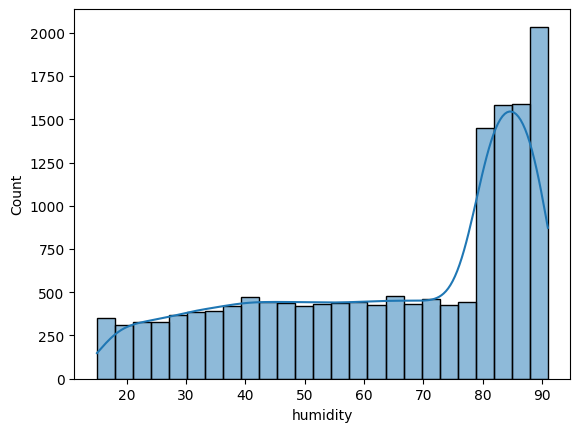

In [11]:
sns.histplot(data = df , x = 'humidity' , kde = True)
plt.show()

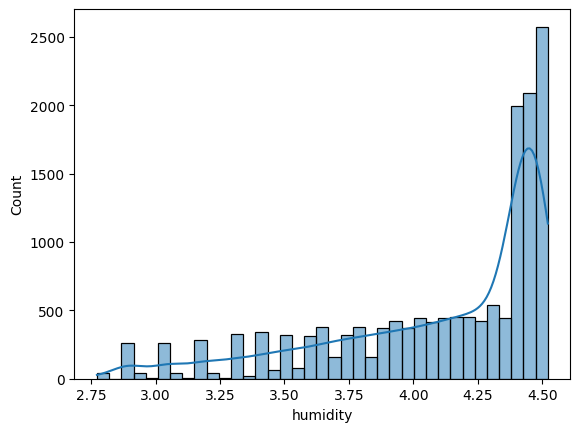

In [12]:
sns.histplot(np.log1p(df['humidity']), kde=True)
plt.show()

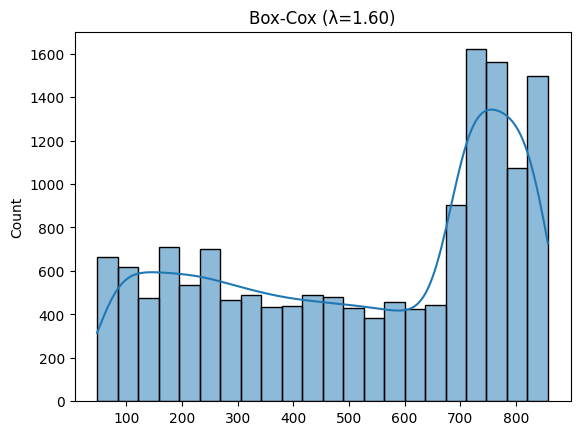

In [13]:
from scipy.stats import boxcox

humidity_bc, lam = boxcox(df['humidity'])
sns.histplot(humidity_bc, kde=True)
plt.title(f'Box-Cox (λ={lam:.2f})')
plt.show()

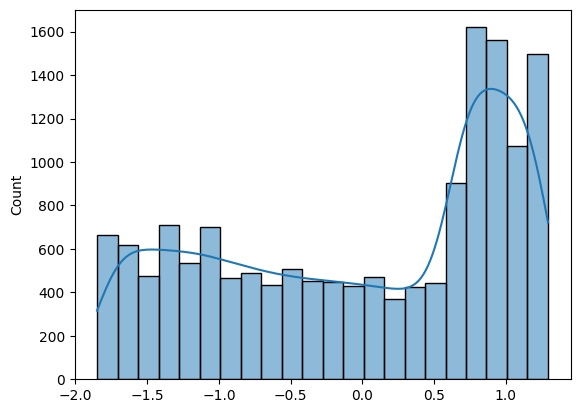

In [14]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
humidity_yj = pt.fit_transform(df[['humidity']])

sns.histplot(humidity_yj.flatten(), kde=True)
plt.show()


In [15]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
humidity_yj = pt.fit_transform(df[['humidity']])

df['humidity'] = humidity_yj.ravel()

In [16]:
drop_cols = ['crop ID', 'soil_type', 'Seedling Stage']
df.drop(columns = drop_cols , axis = 1 , inplace = True)

In [17]:
df.head()

,MOI,temp,humidity,result
0,1,25,0.670709,1
1,2,26,0.509228,1
2,3,27,0.351584,1
3,4,28,0.197834,1
4,5,29,0.048037,1


In [18]:
from sklearn.preprocessing import StandardScaler

scaling_cols = ['temp']

scaler = StandardScaler()

df[scaling_cols] = scaler.fit_transform(df[scaling_cols])

In [19]:
df.head()

,MOI,temp,humidity,result
0,1,-0.344172,0.670709,1
1,2,-0.241438,0.509228,1
2,3,-0.138704,0.351584,1
3,4,-0.035969,0.197834,1
4,5,0.066765,0.048037,1


In [20]:
X = df.drop(columns = ['result'])
y = df['result']

In [21]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [22]:
X_train.shape

(12231, 3)

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score,roc_curve
# from catboost import CatBoostClassifier

In [24]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [25]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [26]:
# Create a function which can evaluate models and return a report
def evaluate_models(X , y , models):

    # Do the train test split
    X_train, X_test, y_train, y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

    models_list = []
    accuracy_list = []
    auc_list = []

    for i in range(len(list(models))):
        # extract the model object and model name
        model = list(models.values())[i]
        model_name = list(models.keys())[i]

        # do the train
        model.fit(X_train , y_train)

        # Do the prediction on training data
        y_train_pred = model.predict(X_train)
        # Do the prediction on test data
        y_test_pred = model.predict(X_test)

        # performance on training data
        model_train_accuracy, model_train_f1,model_train_precision,model_train_recall,model_train_rocauc_score = evaluate_clf(y_train ,y_train_pred)
        # performance on test data
        model_test_accuracy,model_test_f1,model_test_precision,model_test_recall,model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)

        print(f"Model: {model_name}")
        models_list.append(model_name)

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc_list.append(model_test_rocauc_score)
        print('='*35)
        print('\n')

    # make the report
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)

    return report

In [27]:
base_model_report = evaluate_models(X = X , y = y , models = models)

Model: Random Forest
Model performance for Training set
- Accuracy: 0.9719
- F1 score: 0.9661
- Precision: 0.9507
- Recall: 0.9820
- Roc Auc Score: 0.9734
----------------------------------
Model performance for Test set
- Accuracy: 0.9591
- F1 score: 0.9503
- Precision: 0.9351
- Recall: 0.9660
- Roc Auc Score: 0.9602


Model: Decision Tree
Model performance for Training set
- Accuracy: 0.9719
- F1 score: 0.9658
- Precision: 0.9578
- Recall: 0.9739
- Roc Auc Score: 0.9722
----------------------------------
Model performance for Test set
- Accuracy: 0.9545
- F1 score: 0.9441
- Precision: 0.9392
- Recall: 0.9491
- Roc Auc Score: 0.9537


Model: Gradient Boosting
Model performance for Training set
- Accuracy: 0.9658
- F1 score: 0.9589
- Precision: 0.9423
- Recall: 0.9760
- Roc Auc Score: 0.9674
----------------------------------
Model performance for Test set
- Accuracy: 0.9670
- F1 score: 0.9598
- Precision: 0.9444
- Recall: 0.9757
- Roc Auc Score: 0.9684


Model: Logistic Regression
Mod

In [28]:
base_model_report

,Model Name,Accuracy
6,AdaBoost Classifier,0.967299
2,Gradient Boosting,0.966972
4,K-Neighbors Classifier,0.960105
0,Random Forest,0.959124
1,Decision Tree,0.954545
5,Support Vector Classifier,0.917266
3,Logistic Regression,0.851210


In [29]:
model = AdaBoostClassifier()
model.fit(X_train , y_train)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",50
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None


In [30]:
y_pred = model.predict(X_test)
accuracy_score(y_test , y_pred)

0.9672988881621976

In [32]:
model.feature_importances_

array([0.5491981, 0.4508019, 0.       ])

In [33]:
import joblib
joblib.dump(model, "model.pkl")

['model.pkl']

In [34]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pt, "pt.pkl")

['pt.pkl']

In [35]:
model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
pt = joblib.load("pt.pkl")

In [36]:
def predict_from_raw_input(raw_df: pd.DataFrame):
    """
    raw_df columns:
    ['MOI', 'temp', 'humidity']
    """

    df = raw_df.copy()

    # -------- 1. Power transform humidity --------
    df['humidity'] = pt.transform(df[['humidity']]).ravel()

    # -------- 3. Scale temperature --------
    df[['temp']] = scaler.transform(df[['temp']])

    # -------- 4. Prediction --------
    predictions = model.predict(df)

    return predictions

In [37]:
sample_input = pd.DataFrame({
    'MOI': [0.45],
    'temp': [32.5],
    'humidity': [78.0]
})

pred = predict_from_raw_input(sample_input)
print(pred)

[1]
